## Philippine SMS Scam Identification via BiLSTM

by NGianan and FManahan

*adapted from: [NLP: Spam Detection in SMS (text) data using Deep Learning](https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8)*

**Scam ba 'to?** aims to empower Philippine users to determine whether an SMS they received is fraudulent or legitimate. Under the hood is a Bidirectional-Long Short Term Memory (Bi-LSTM) deep learning model that reads text input and detects malicious intent.

### Required Packages

In [5]:
# for tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, ImageColorGenerator
%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# libraries for modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

### Data Gathering and Generation

We crowdsourced [messages](https://docs.google.com/spreadsheets/d/1oxRYeeRxAj2cAOSM5bk6RJOImoQ4SoryOJE1KxZAuJ0/edit#gid=232115380) crowdsourced from local volunteers who shared a total of 130 labeled scam (65) and legitimate (65) text messages. 

In [6]:
# loading the original data
original = pd.read_csv('original.csv', sep =',', usecols = ["Message", "Tag"])
original.columns = ["message", "label"]
original.head()

,message,label
0,UNLI FREE DELIVERY until Apr. 30 at Waltermart...,ham
1,Hi! We've successfully completed our system ac...,ham
2,Hi! There will be a system activity from April...,ham
3,"Hi, I have arrived at your address with your E...",ham
4,"Hi po! Grab express po ito, nandito na po ako ...",ham


In [7]:
original.describe()

,message,label
count,130,130
unique,129,2
top,"Hi,I'm the Hiring Manager.You have been select...",ham
freq,2,65


Text(0.5, 1.0, 'Distribution of ham and scam messages in the Original Dataset')

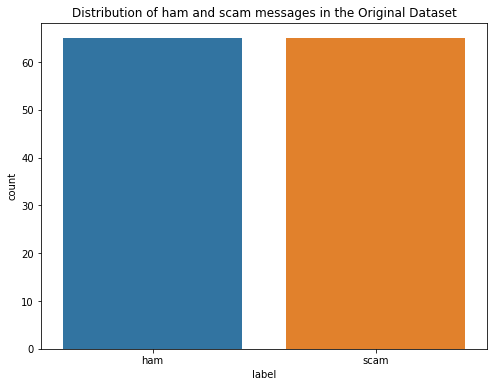

In [8]:
# checking the count of ham and scam messagse 
plt.figure(figsize=(8,6))
sns.countplot(x = original.label)
plt.title('Distribution of ham and scam messages in the Original Dataset')

Since we needed more messages for this study, we created synthetic data using Gretel's Python SDK in a Google Colab [notebook](https://colab.research.google.com/github/gretelai/gretel-blueprints/blob/main/docs/notebooks/create_synthetic_data_from_a_dataframe_or_csv.ipynb?authuser=2#scrollTo=UTRxpSlaczHY). Here we generated 1,979 additional [messages](https://docs.google.com/spreadsheets/d/1oxRYeeRxAj2cAOSM5bk6RJOImoQ4SoryOJE1KxZAuJ0/edit#gid=249748673) with a field distribution close to the original data. 

In [9]:
# loading the original data
synthetic = pd.read_csv('synthetic_final.csv', sep =',', usecols = ["Message", "Tag"])
synthetic.columns = ["message", "label"]
synthetic.head()

,message,label
0,gg purchase.,ham
1,SM G FSep pinat,scam
2,Thank you for your understanding.,ham
3,era purchaseion!!,ham
4,sustLOTS777.PH,scam


In [10]:
synthetic.describe()

,message,label
count,1979,1979
unique,1370,2
top,Hi! You may have been unable to view the O.R. ...,ham
freq,94,1001


Text(0.5, 1.0, 'Distribution of ham and scam messages in the Synthetic Dataset')

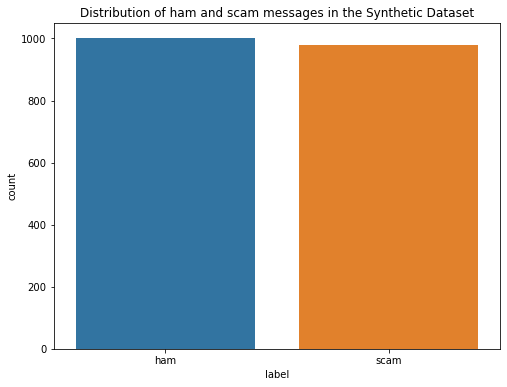

In [11]:
# checking the count of ham and scam messagse 
plt.figure(figsize=(8,6))
sns.countplot(x = synthetic.label)
plt.title('Distribution of ham and scam messages in the Synthetic Dataset')

### Data Preparation and Exploration

The original and synthetic datasets were combined for this activity.  

In [12]:
# combining the data
messages = pd.concat([original, synthetic], ignore_index=True)
messages.head()

,message,label
0,UNLI FREE DELIVERY until Apr. 30 at Waltermart...,ham
1,Hi! We've successfully completed our system ac...,ham
2,Hi! There will be a system activity from April...,ham
3,"Hi, I have arrived at your address with your E...",ham
4,"Hi po! Grab express po ito, nandito na po ako ...",ham


In [13]:
messages.describe()

,message,label
count,2109,2109
unique,1494,2
top,Hi! You may have been unable to view the O.R. ...,ham
freq,95,1066


Text(0.5, 1.0, 'Distribution of ham and scam messages')

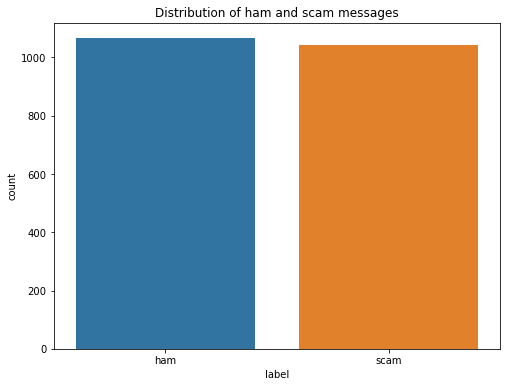

In [14]:
# checking the count of ham and scam messagse 
plt.figure(figsize=(8,6))
sns.countplot(x = messages.label)
plt.title('Distribution of ham and scam messages')

On the average, scam messages are shorter:

In [15]:
# getting the length column for each text
messages['text_length'] = messages['message'].apply(len)

# calculating the average length by label type
labels = messages.groupby('label').mean()
labels

,text_length
label,
ham,182.014071
scam,104.842761


To prepare the data for modeling, we remove [Tagalog](https://github.com/stopwords-iso/stopwords-tl/blob/master/stopwords-tl.txt) and [nltk english](https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a) stopwords. Usually, in NLP pre-processing, text data are also converted to lowercase but this will be done by the `Tokenizer` later.  

In [16]:
# loading the stopwords
stop_words_ls = pd.read_csv('stopwords.csv', header = None)
stop_words = tuple(list(stop_words_ls[0]))

# removal of stopwords
messages['msg_clean'] = messages['message'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))

# function to remove stopwords, which will be used in the prediction function later. 
def no_stop(data):
    output_array=[]
    for sentence in data:
        temp_list=[]
        for word in sentence.split():
            if word.lower() not in stop_words:
                temp_list.append(word)
        output_array.append(' '.join(temp_list))
    return output_array

In [17]:
# separating the ham and scam messages
ham = messages[messages.label =='ham']
scam = messages[messages.label=='scam']

# creating numpy list to visualize using wordcloud
ham_text = " ".join(ham.message.to_numpy().tolist())
scam_text = " ".join(scam.message.to_numpy().tolist())

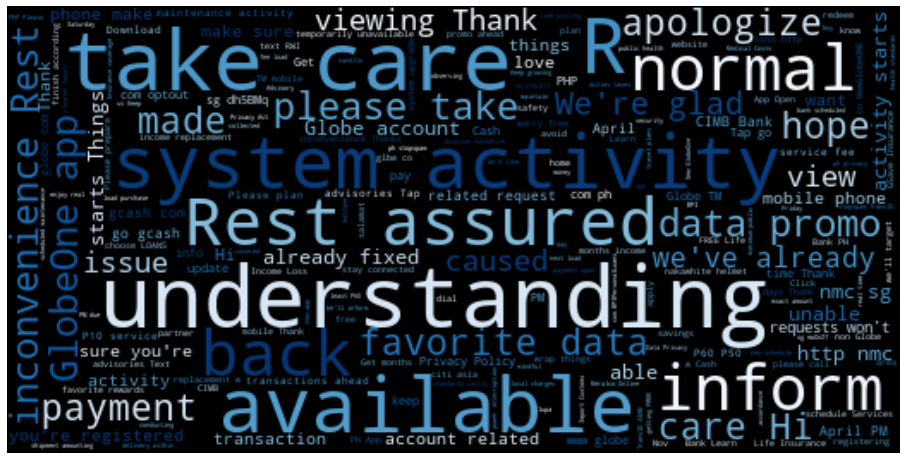

In [18]:
# wordcloud of ham messages
ham_cloud = WordCloud(width =520, height =260, stopwords=stop_words, max_font_size=50, 
                          background_color ="black", colormap='Blues').generate(ham_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_cloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

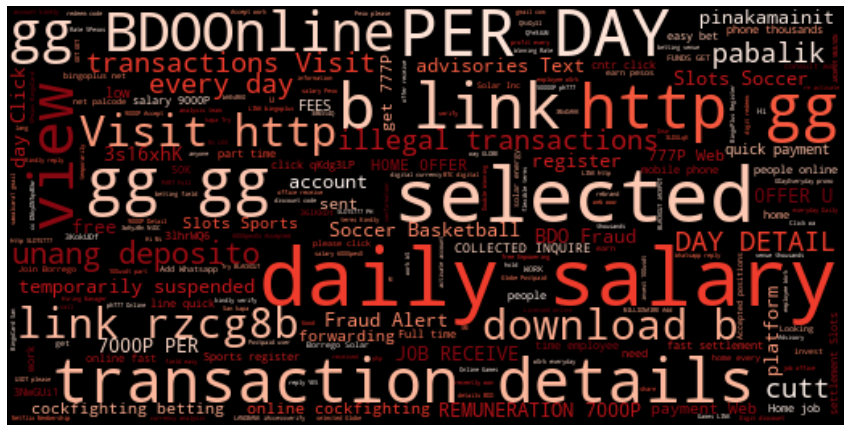

In [19]:
# wordcloud of scam messages
scam_cloud = WordCloud(width =520, height =260, stopwords=stop_words, max_font_size=50, 
                          background_color ="black", colormap='Reds').generate(scam_text)
plt.figure(figsize=(15,10))
plt.imshow(scam_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

Then labels are vectorized. 

In [20]:
# converting text label to numeric, tagging ham messages- 0 and scam messages- 1
messages['msg_type']= messages['label'].map({'ham': 0, 'scam': 1})
message_label = messages['msg_type'].values
message_label

array([0, 0, 0, ..., 0, 1, 0])

We then split the data into testing (80%) and training (20%) sets. 

In [21]:
# splitting data into train and test, 80% for training and 20% for testing
train_msg, test_msg, train_labels, test_labels = train_test_split(messages['msg_clean'], message_label, test_size=0.2, random_state=13)

For the machine to understand the messages, **tokenization**, **vectorization**, and **sequencing** will be done. 

**Tokenization** is the process of splitting the text elements into tokens, in this case, words. This is done via the TensorFlow `Tokenizer` API. After tokenization, the tokens are **vectorized** or mapped to a number via `tokenizer.fit_on_texts`. Sentences are then **sequenced** or represented by arranging the numbers in the order the words are written. This is done by `tokenizer.texts_to_sequences`

For these processes, the following hyperparameters are defined:

In [22]:
# defining pre-processing hyperparameters

# for tokenization
oov_tok = "<OOV>" # out of vocabulary token, words not encountered in training are mapped to this token
vocab_size = 200 # maximum number of words to keep, n most frequent words

# for sequence generation
max_len = 80 # maximum number of words per entry to be considered
trunc_type = "post" # removes numbers from the end of the sequence to stay within max_len
padding_type = "post" # adds zeroes to the end of the sequence to reach max_len

In [23]:
# tokenizer goes through the training data to separate the words
tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level=False, # tokenization will be done per word
                      oov_token = oov_tok)

# then every token gets a unique integer value
tokenizer.fit_on_texts(train_msg)

In [24]:
# word_index is the full list of tokens
word_index = tokenizer.word_index

# checking the total number of unique words in the dataset
len(word_index)

1830

Tokenization resulted in 1,830 tokens

In [25]:
word_index

{'<OOV>': 1,
 'activity': 2,
 'ly': 3,
 'https': 4,
 'account': 5,
 'bit': 6,
 'hi': 7,
 'thank': 8,
 'take': 9,
 'globe': 10,
 'care': 11,
 'understanding': 12,
 'please': 13,
 'app': 14,
 '10': 15,
 'o': 16,
 'r': 17,
 'get': 18,
 'available': 19,
 'things': 20,
 'system': 21,
 'payment': 22,
 'click': 23,
 'time': 24,
 'http': 25,
 'text': 26,
 'day': 27,
 'transactions': 28,
 'link': 29,
 'view': 30,
 'promo': 31,
 'free': 32,
 'online': 33,
 'assured': 34,
 'inform': 35,
 'rest': 36,
 'you': 37,
 'inconvenience': 38,
 'mobile': 39,
 'com': 40,
 'data': 41,
 'favorite': 42,
 'home': 43,
 'normal': 44,
 'back': 45,
 'april': 46,
 'pm': 47,
 'selected': 48,
 'globeone': 49,
 'register': 50,
 'now': 51,
 'gg': 52,
 'apologize': 53,
 'phone': 54,
 '2022': 55,
 'cash': 56,
 'hope': 57,
 'ph': 58,
 'fixed': 59,
 "we're": 60,
 '1': 61,
 'made': 62,
 'glad': 63,
 'viewing': 64,
 'salary': 65,
 'it': 66,
 'keep': 67,
 'caused': 68,
 "we've": 69,
 'already': 70,
 'issue': 71,
 'web': 72,
 'a

In [26]:
# using the generated word index, text_to_sequences() creates sequences of numbers, to represent each text entry in the dataset. OOV words are assigned a value of 1.
training_sequences = tokenizer.texts_to_sequences(train_msg)
testing_sequences = tokenizer.texts_to_sequences(test_msg)

# sequences are padded with zeroes so they are all of the same length (max_len)
training_padded = pad_sequences (training_sequences, maxlen = max_len, 
                                 padding = padding_type, truncating = trunc_type )
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)
# checking the padding
print(training_padded[0])

[  1   1   1   1   1   1 168  15   1 136  24  43 106   1   1   1 109  27
  23 131 111   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]


In [27]:
### Recurrent Neural Network: Bi-Long Short Term Memory Neural Network 

A **Recurrent Neural Network (RNN)** is a a type of neural network used specifically for sequential data, like time series and text data. 

Typically, a neuron in an RNN receives an input value, say, the first word in a sentence, and a function processes this to produce an output value. This step also produces a *feed-forward value* which is passed to the next neuron, as it receives the next word for processing. This neuron learns from the all the information provided and passes this down the network. As this happens over a long sequence though, the context provided by words in the first part of the sentence may be diluted or lost. 

This is resolved by **Long Short Term Memory Networks**, a type of which is **Bi-Long Short Term Memory (Bi-LSTM)**. Here a *cell state*, or a context is remembered across the network. It is bi-directional, meaning later words in the sentence can also provide context to the earlier ones. 

In the next few steps, we will **define** the neural network layers and **compile** them, after which, we **train** the model.  

In [28]:
# BiLSTM hyperparameters
n_lstm = 15 # the number of nodes in the hidden layers
drop_lstm =0.50 # retention probability or the probability for a layer, or the probability that the layer is a dropped. Dropout is a regularization method to prevent neural networks from overfitting by randomly disabling neurons and their connections
vocab_size = 200 # maximum number of words to keep, n most frequent words
embeding_dim = 16 # in the first layer of the network, embedding maps each word to an n-dimensional vector of the defined size

In [29]:
# re-shaping the label data for the NN
train_labels_reshaped = np.asarray(train_labels).astype('float32').reshape((-1,1))
test_labels_reshaped = np.asarray(test_labels).astype('float32').reshape((-1,1))

In [30]:
# defining the NN layers
model = Sequential() # layers are added in a linear sequence
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm))) # defining the Bi-directional LSTM layer
model.add(Dense(1, activation='sigmoid')) # sigmoid activation function outputs a value from 0 to 1

In [31]:
# compiling the model, where the layers that were defined previously are transformed into a format that can be run by one's machine
model.compile(loss = 'binary_crossentropy', # loss function used for binary outputs
               optimizer = 'adam', # the optimizer is an algorithm that modifies weights and learning rates in a NN to reduce loss and improve accuracy. 'Adam' is a type of algorithm.
               metrics=['accuracy'])

In [32]:
# training the model
num_epochs = 30 # the number of times the algorithm will go through the dataset
early_stop = EarlyStopping(monitor='val_loss', patience=2) # model training is stopped if validation loss does not improve after 2 epochs, to prevent overfitting
history = model.fit(training_padded, train_labels_reshaped, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels_reshaped),callbacks =[early_stop], verbose=1)

Epoch 1/30
53/53 [==============================] - 5s 36ms/step - loss: 0.6847 - accuracy: 0.6117 - val_loss: 0.6556 - val_accuracy: 0.8223
Epoch 2/30
53/53 [==============================] - 1s 24ms/step - loss: 0.5145 - accuracy: 0.8210 - val_loss: 0.3976 - val_accuracy: 0.8531
Epoch 3/30
53/53 [==============================] - 1s 25ms/step - loss: 0.3239 - accuracy: 0.8743 - val_loss: 0.2623 - val_accuracy: 0.9028
Epoch 4/30
53/53 [==============================] - 1s 24ms/step - loss: 0.2404 - accuracy: 0.9057 - val_loss: 0.2262 - val_accuracy: 0.9005
Epoch 5/30
53/53 [==============================] - 1s 23ms/step - loss: 0.2004 - accuracy: 0.9271 - val_loss: 0.2146 - val_accuracy: 0.9005
Epoch 6/30
53/53 [==============================] - 1s 22ms/step - loss: 0.1876 - accuracy: 0.9289 - val_loss: 0.2202 - val_accuracy: 0.9005
Epoch 7/30
53/53 [==============================] - 1s 23ms/step - loss: 0.1822 - accuracy: 0.9324 - val_loss: 0.1781 - val_accuracy: 0.9123
Epoch 8/30
53

To evaluate our model, we will look at accuracy and loss. Accuracy is the percentage of data classified correctly while loss, simply put, represents the difference between the true values and the model's predictions. The loss and accuracy curves will show us the progress of the model's learning process at every epoch. 

In [33]:
# visualizing the metrics
metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs(var1, var2, string):
    plt.clf()
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2]) 

<Figure size 432x288 with 0 Axes>

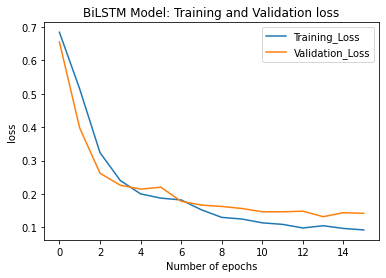

In [34]:
plot_graphs('Training_Loss', 'Validation_Loss', 'loss')

Here we can see that loss drops as the epochs increases. Training and validation loss curves are also close to each other. These are indicators of a good fit model. 

<Figure size 432x288 with 0 Axes>

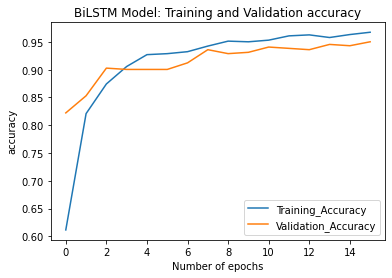

In [35]:
plot_graphs('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

The plot above shows that accuracy increases over epochs. The small gap between the curves indicate that we have a good fit model. 

In [36]:
print(f"Bi-LSTM architecture loss and accuracy: {model.evaluate(testing_padded, test_labels_reshaped)} " )

14/14 [==============================] - 0s 5ms/step - loss: 0.1420 - accuracy: 0.9502
Bi-LSTM architecture loss and accuracy: [0.1419554352760315, 0.950236976146698] 


We now test the model using messages that it has not seen yet:

In [37]:
predict_msg = ["Hello valued customer, thank you for your patience. You may now access CIMB on GSave Marketplace. Rest assured that you GSave funds are safe with us.",
               "SOLAR 3 WAY LIGHTS SOBRA GANDA AT FORMAL ILAGAY SA WALL CLICK FOR PRICE/BUY ---> https://s.lazada.com.ph/s.V9Nyq",
               "I am a eBay project manager, we are hiring a part-time team, you can work from home, daily salary: 3000-8000, add Whatsapp: wa.me/639359491743", 
               "Cryptocurrency game registration to get 588, click to join us: https://cutt.ly/hH2iQWB"]

In [38]:
def predict_spam(predict_msg):
    clean = no_stop(predict_msg)
    new_seq = tokenizer.texts_to_sequences(clean)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return model.predict(padded)

In [39]:
predict_spam(predict_msg)

1/1 [==============================] - 1s 611ms/step


array([[0.00243858],
       [0.93986297],
       [0.9956001 ],
       [0.9941106 ]], dtype=float32)

#### References:
- [NLP: Spam Detection in SMS (text) data using Deep Learning](https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8)
- [Natural Language Processing - (Series)](https://www.youtube.com/watch?v=fNxaJsNG3-s)
- [Long Short-Term Memory for NLP (NLP Zero to Hero)](https://www.youtube.com/watch?v=A9QVYOBjZdY)
- [Deep Learning for NLP: ANNs, RNNs and LSTMs explained!](https://towardsdatascience.com/deep-learning-for-nlp-anns-rnns-and-lstms-explained-95866c1db2e4)
- [Create synthetic data from a dataframe or CSV](https://colab.research.google.com/github/gretelai/gretel-blueprints/blob/main/docs/notebooks/create_synthetic_data_from_a_dataframe_or_csv.ipynb?authuser=2#scrollTo=UTRxpSlaczHY)
- [How To Build And Train An Artificial Neural Network](https://nickmccullum.com/python-deep-learning/artificial-neural-network-tutorial/)
- [Dropout Regularization in Neural Networks: How it Works and When to Use It](https://programmathically.com/dropout-regularization-in-neural-networks-how-it-works-and-when-to-use-it/)
- [How do I remove stop words from an arraylist of strings in python](https://stackoverflow.com/questions/52361543/how-do-i-remove-stop-words-from-an-arraylist-of-strings-in-python)